In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from copy import deepcopy as cdc
h5_new='/Volumes/molly/20220602alltrials_LD.h5'
h5_old='/Volumes/molly/20220511alltrials_LD.h5'
h5_120s='/Volumes/molly/20220603alltrials_start_LD.h5'

In [3]:
df=pd.read_hdf(h5_new, key='df')
df_old=pd.read_hdf(h5_old, key='df')
df_120s=pd.read_hdf(h5_120s, key='df')

In [112]:
df

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000,9.675
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040


In [109]:
df_old

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000


In [162]:
df_120s

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",119.995,0.075000,6.185,0.444444,0.250000,9.675
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040


In [163]:
df_120s['filename']=df_120s['filename'].astype('str')

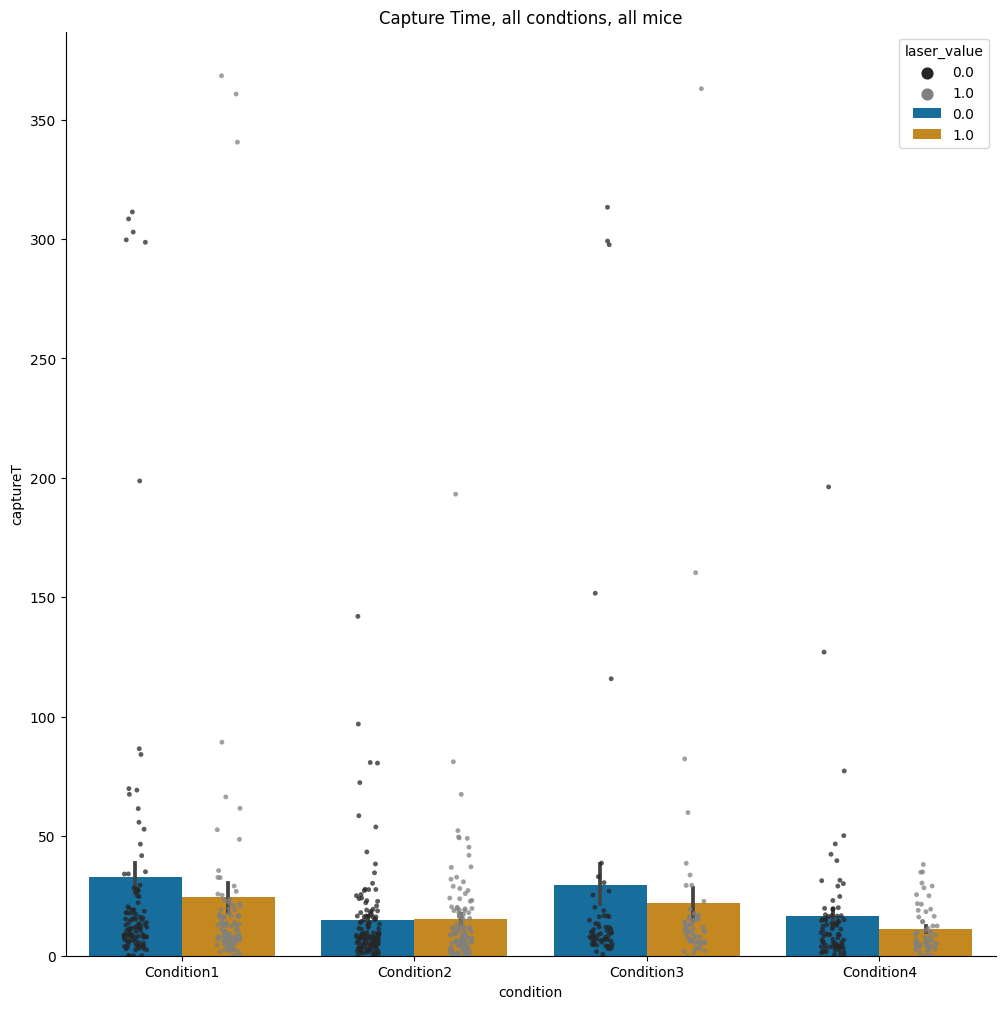

In [114]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice')
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
sns.despine()

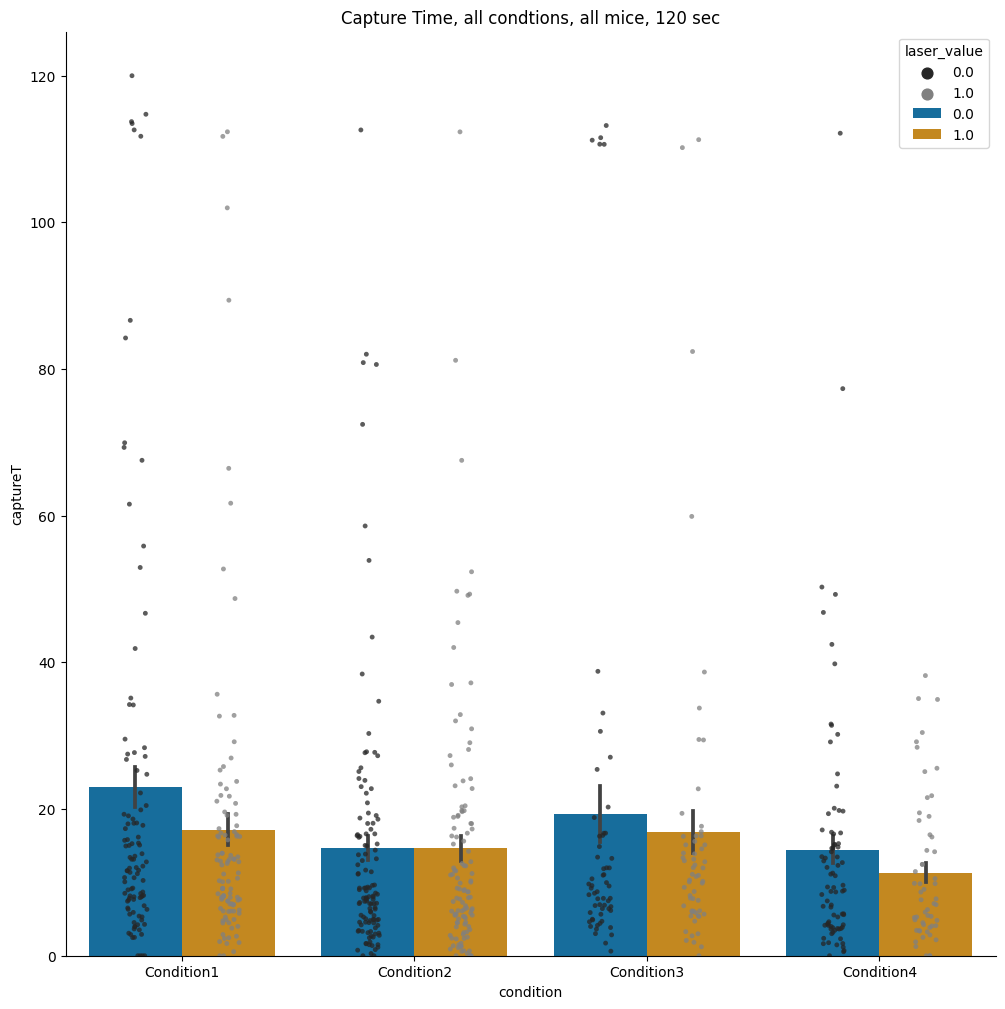

In [165]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df_120s, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df_120s, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice, 120 sec')
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
sns.despine()

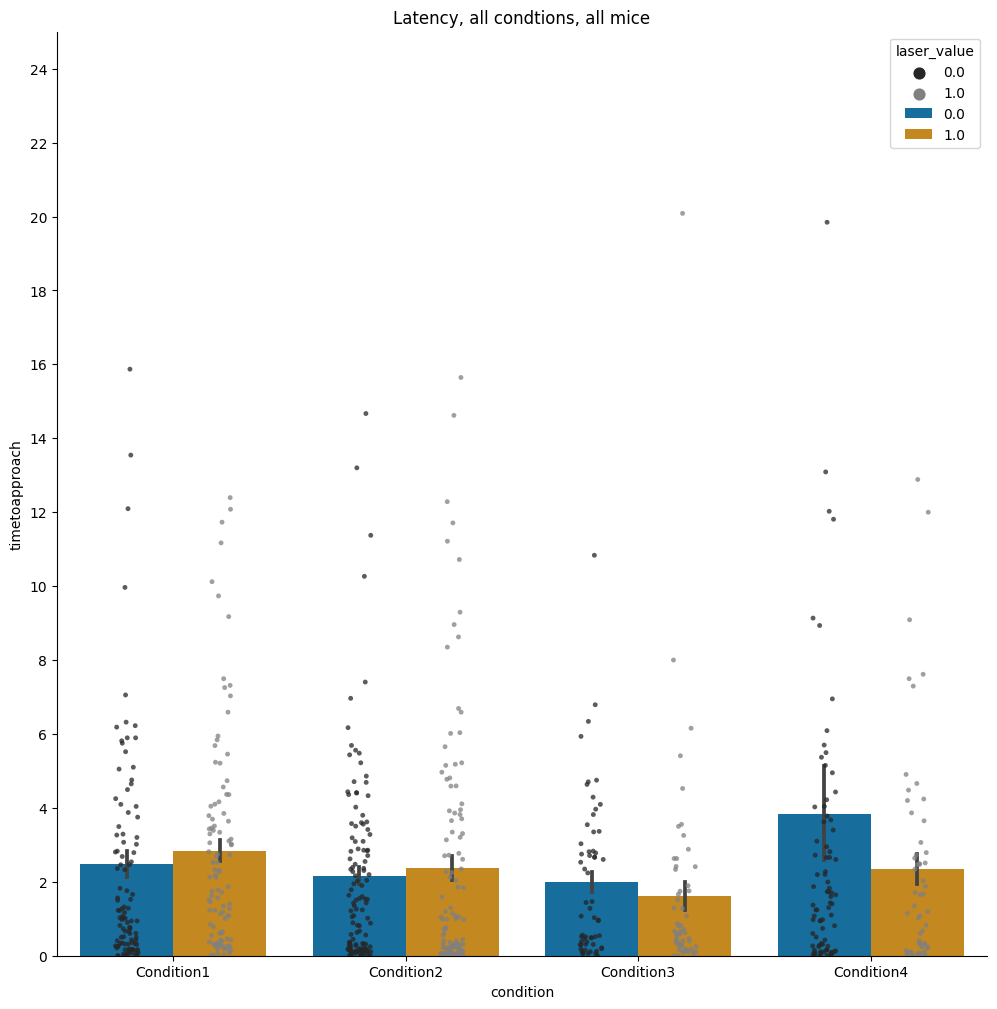

In [115]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='timetoapproach', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='timetoapproach', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Latency, all condtions, all mice')
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))
sns.despine()

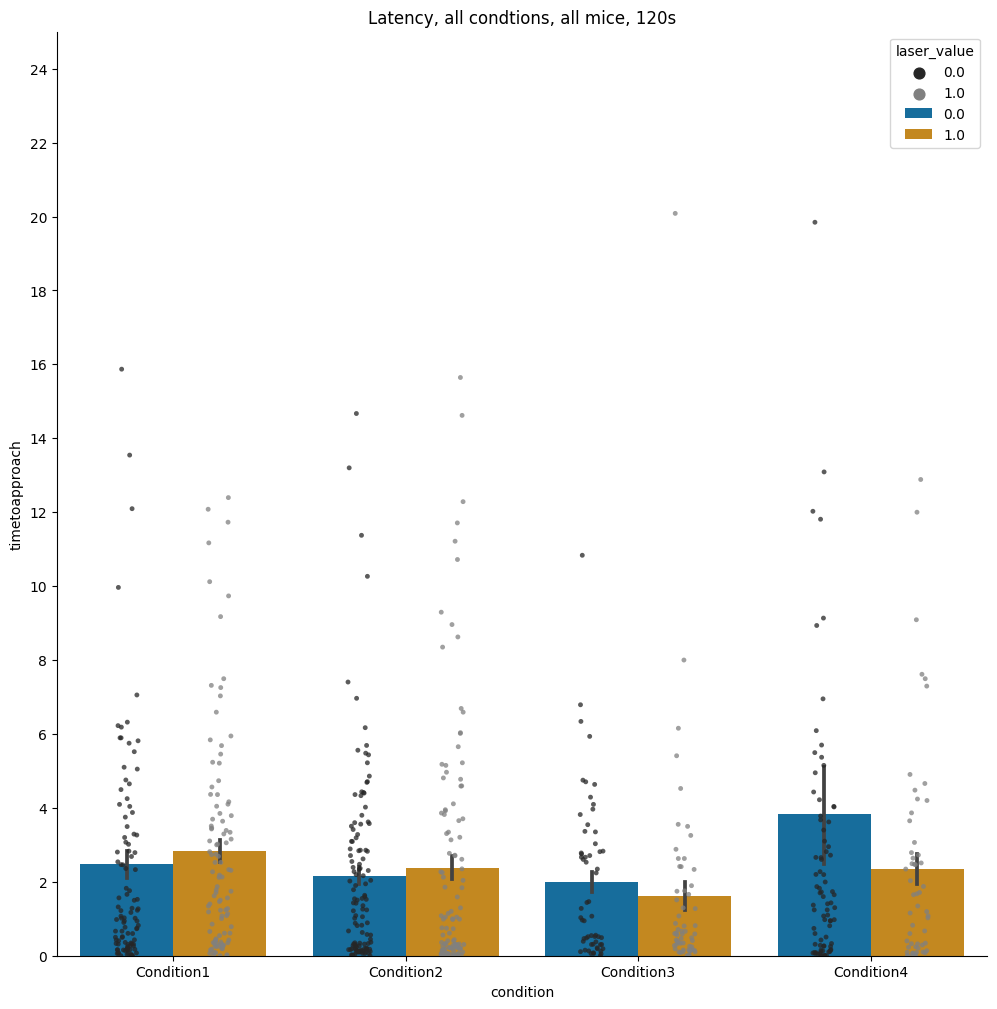

In [169]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df_120s, x='condition', y='timetoapproach', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='timetoapproach', hue='laser_value',dodge=True, data=df_120s, color='gray', size=3.5, alpha=0.75)
plt.title('Latency, all condtions, all mice, 120s')
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))
sns.despine()

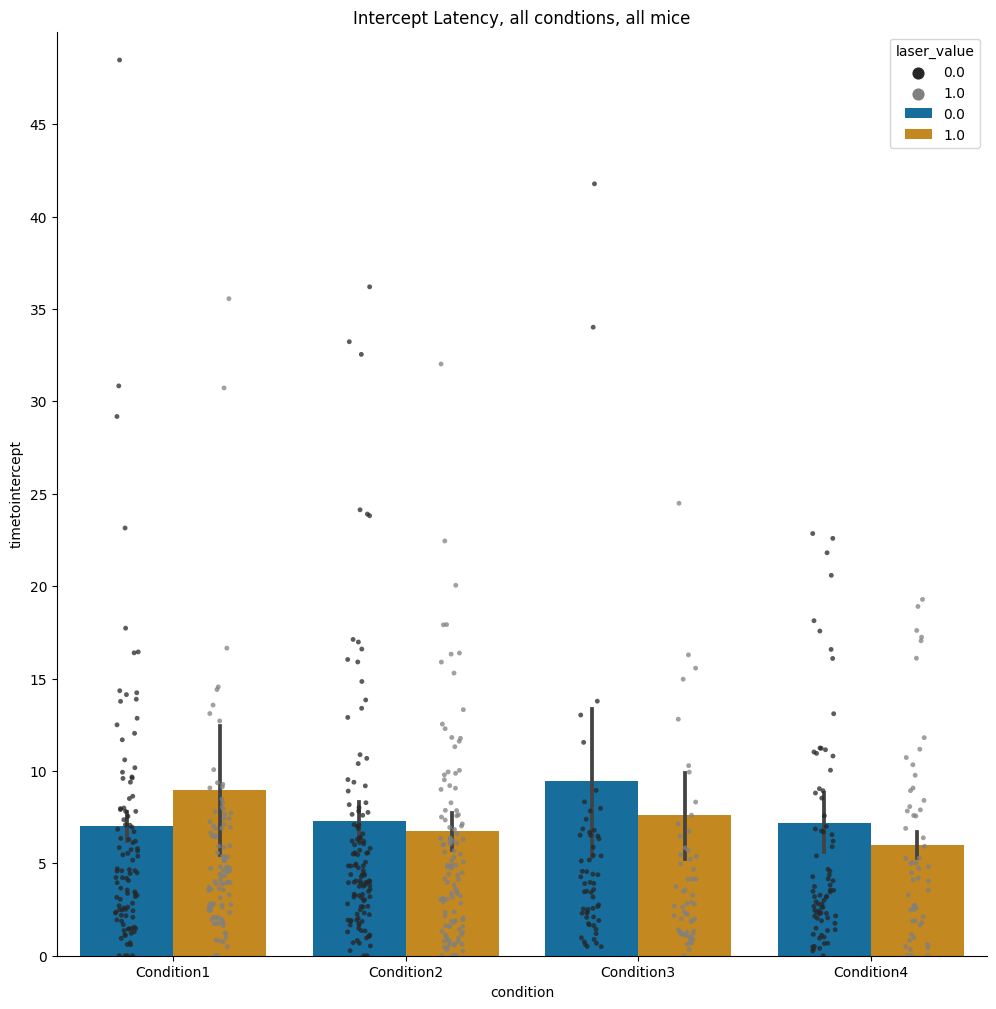

In [119]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='timetointercept', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Intercept Latency, all condtions, all mice')
plt.ylim(0,50)
plt.yticks(np.arange(0,50,5))
sns.despine()

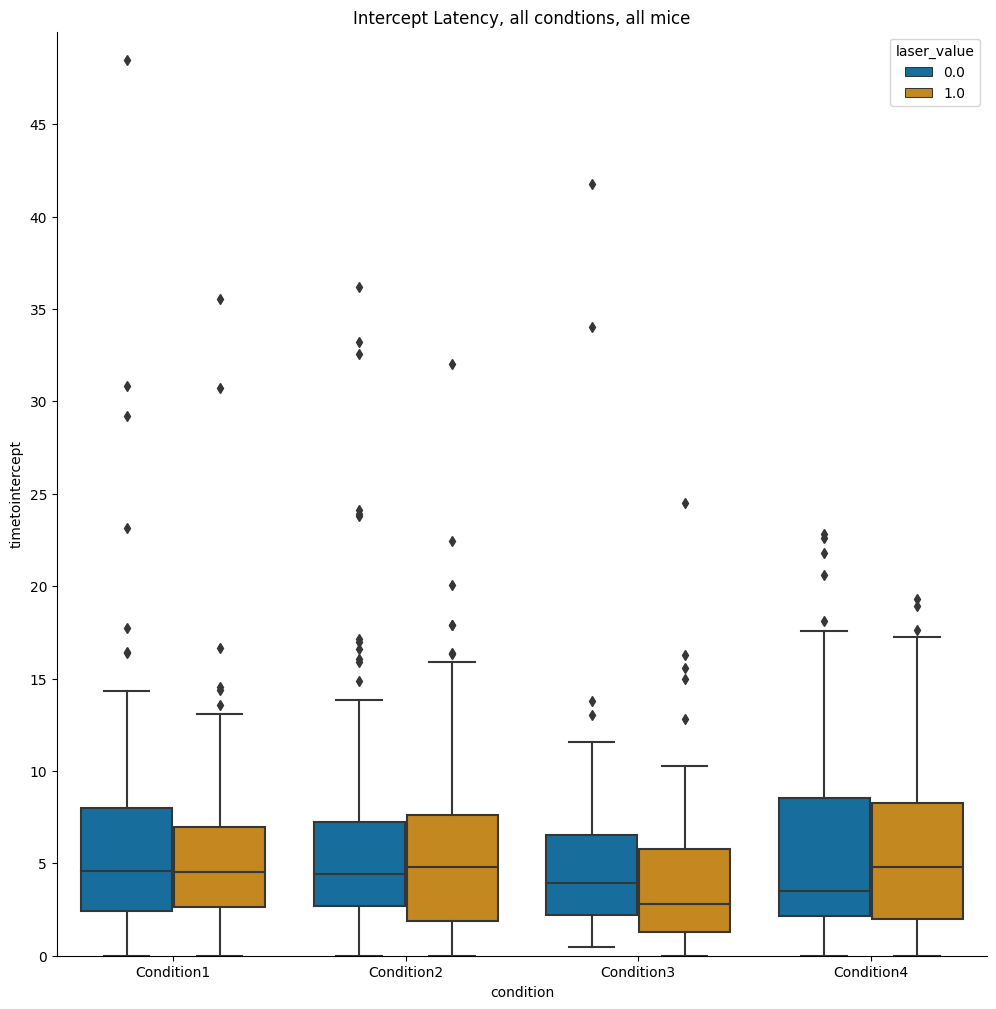

In [159]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='timetointercept', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Intercept Latency, all condtions, all mice')
plt.ylim(0,50)
plt.yticks(np.arange(0,50,5))
sns.despine()

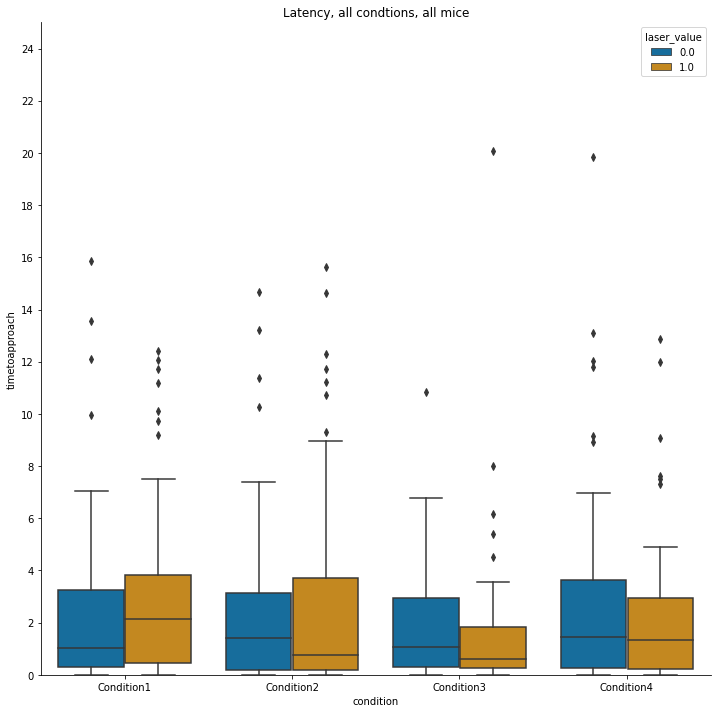

In [11]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='timetoapproach', hue='laser_value',  palette="colorblind")
# ax= sns.stripplot(x='condition', y='timetoapproach', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Latency, all condtions, all mice')
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))
sns.despine()

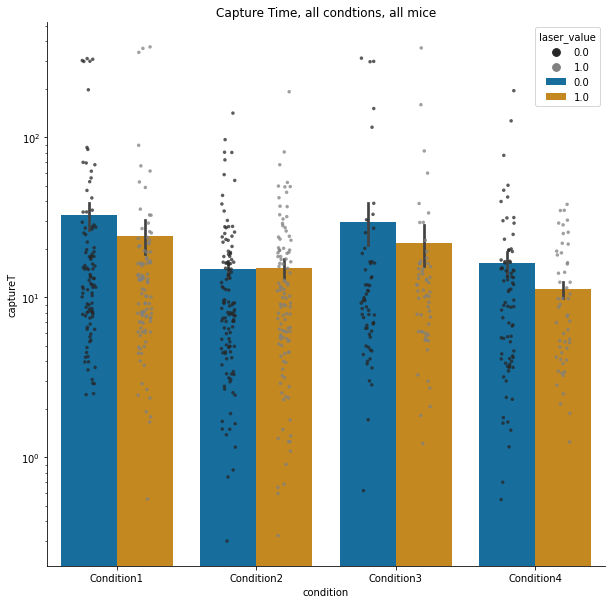

In [12]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, all mice')
# plt.ylim(0,50)
sns.despine()

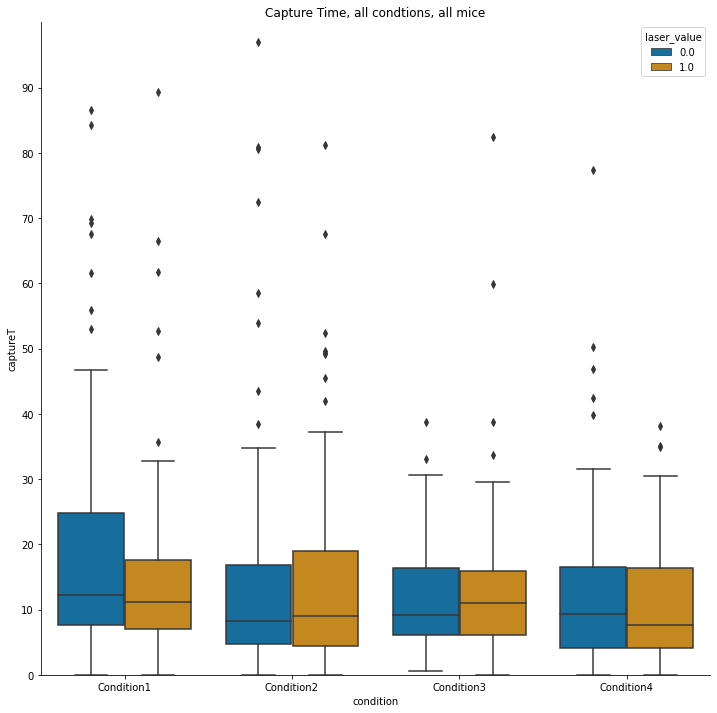

In [13]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind")
plt.title('Capture Time, all condtions, all mice')
plt.ylim(0,100)
plt.yticks(np.arange(0,100,10))
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

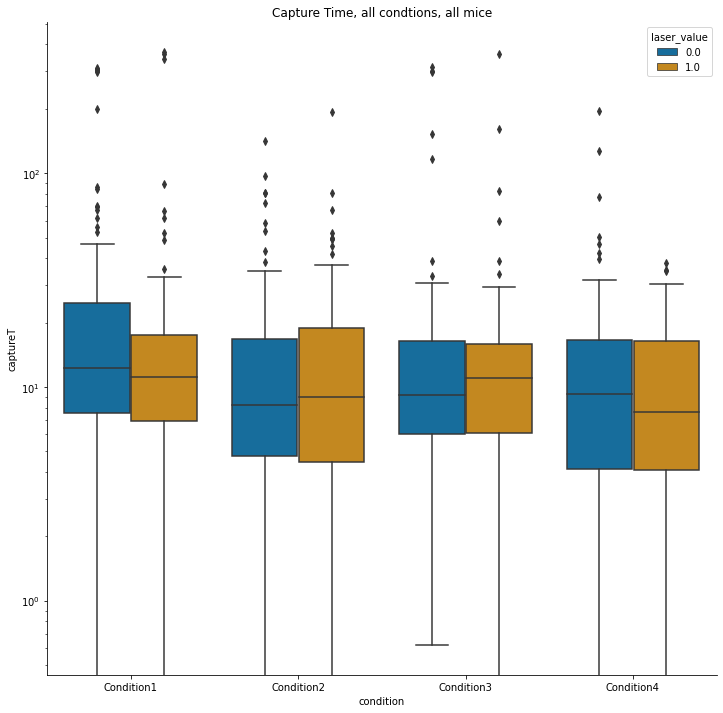

In [14]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind")
ax.set_yscale('log')
plt.title('Capture Time, all condtions, all mice')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

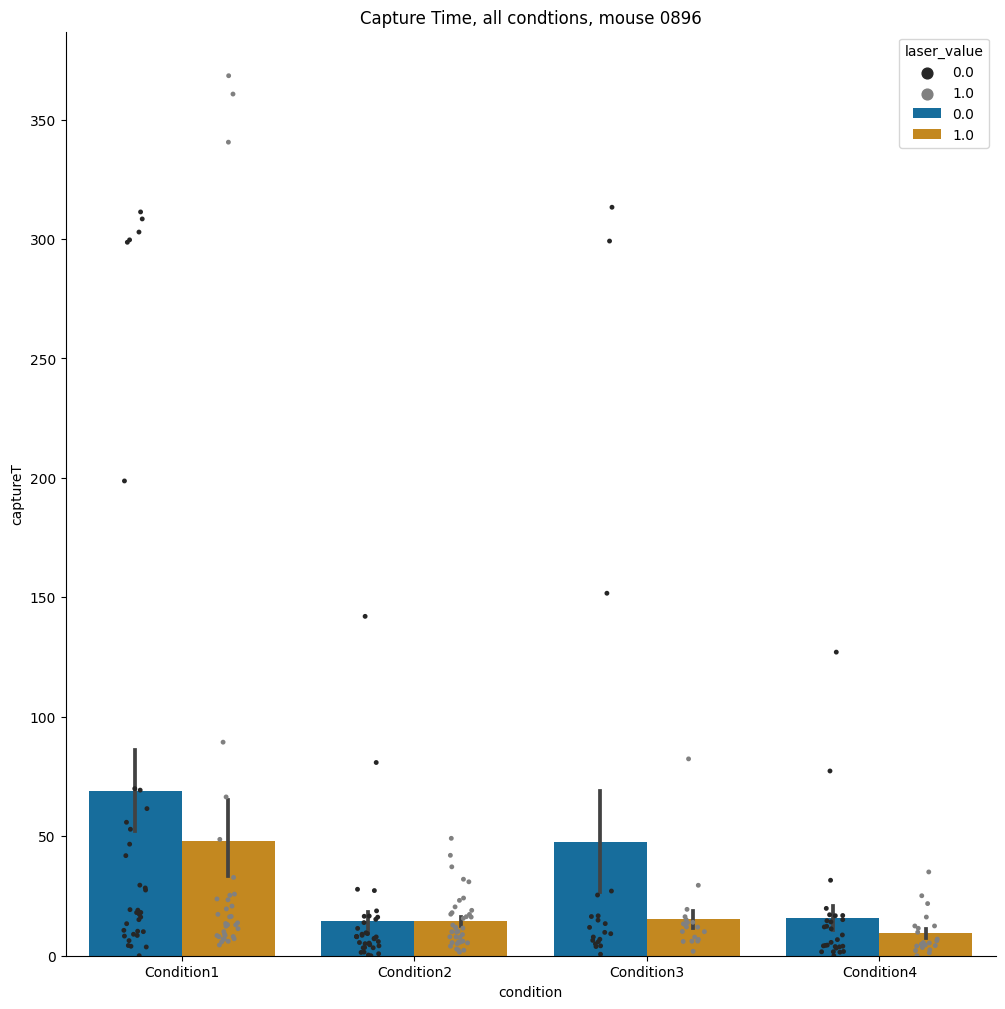

In [122]:
df['filename']=df['filename'].astype('str')
df0896=df[df['filename'].str.contains('0896')]
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0896, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# # plt.ylim(0,50)
plt.title('Capture Time, all condtions, mouse 0896')
sns.despine()

In [123]:
df0896

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000,9.675
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[11.865312396373886, 13.241495111195926, 14.35...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",6.965,0.099034,2.790,0.250000,1.000000,6.890
700,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.4527342519468733, 1.5778002732348897, 1.746...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.240,0.101587,0.075,0.250000,1.000000,4.110
701,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[11.00310606766738, 13.704135400263457, 16.247...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",11.480,0.161929,0.035,0.555556,0.200000,5.280
702,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[9.180225662925693, 10.100061265704785, 10.434...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2.165,0.084087,0.135,0.500000,1.000000,2.115


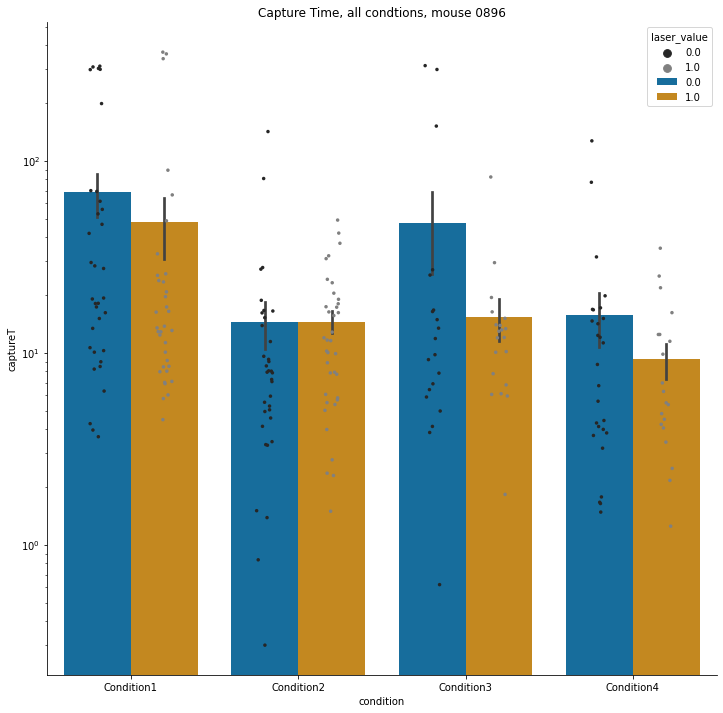

In [18]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0896, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0896')
sns.despine()

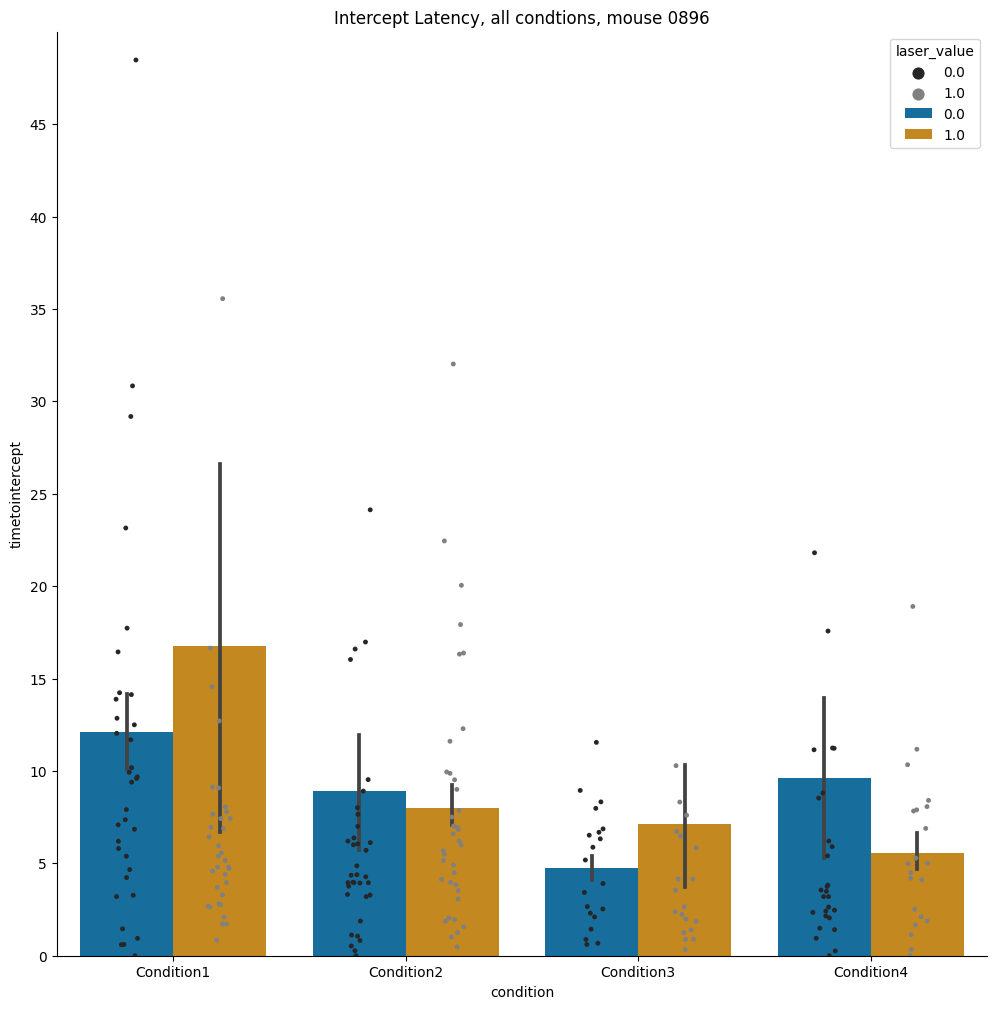

In [128]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0896, x='condition', y='timetointercept', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
plt.ylim(0,50)
plt.yticks(np.arange(0,50,5))
plt.title('Intercept Latency, all condtions, mouse 0896')
sns.despine()

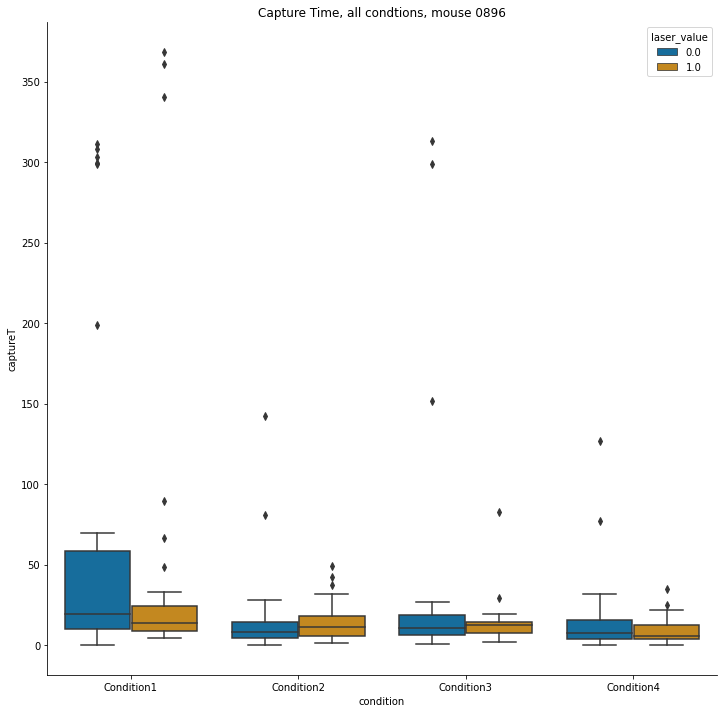

In [19]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df0896, x='condition', y='captureT', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0896')
sns.despine()

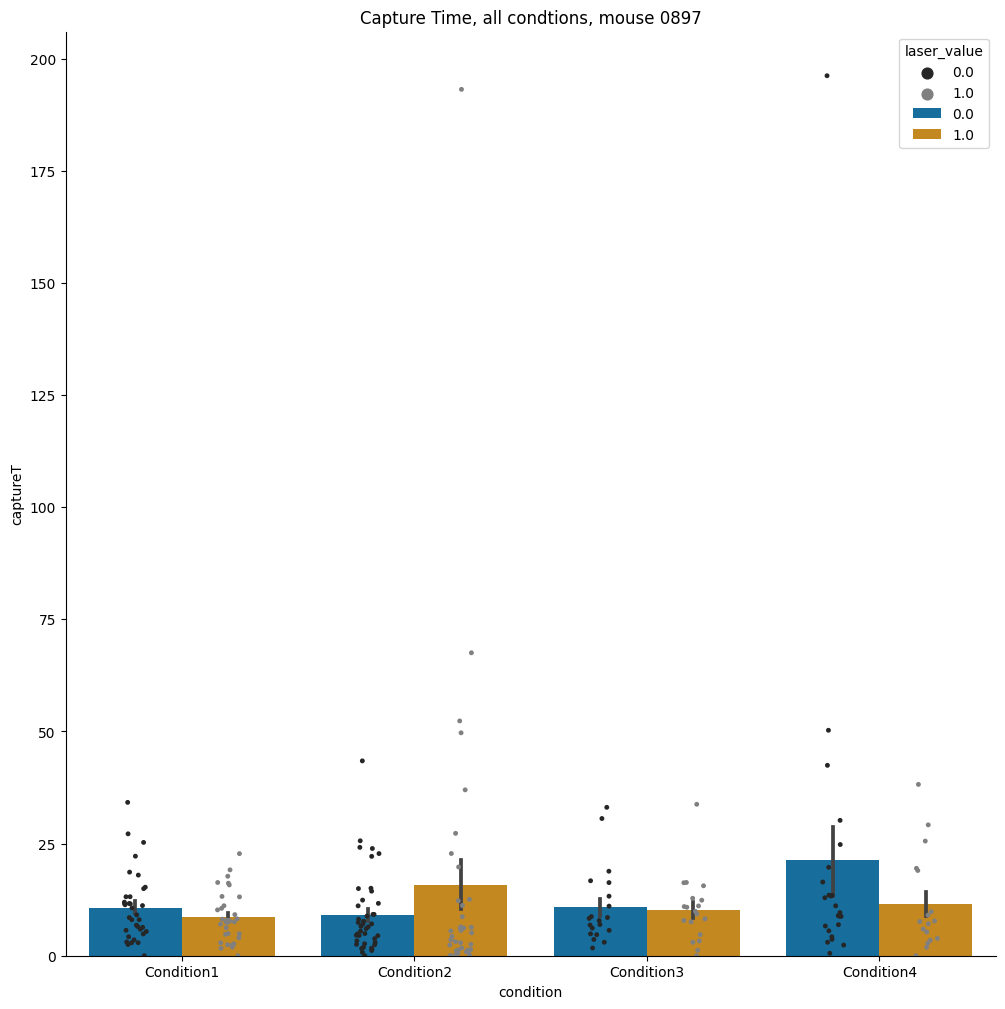

In [125]:
df0897=df[df['filename'].str.contains('0897')]
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0897, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0897, color='gray', size=3.5)
plt.title('Capture Time, all condtions, mouse 0897')
# # plt.ylim(0,50)
sns.despine()

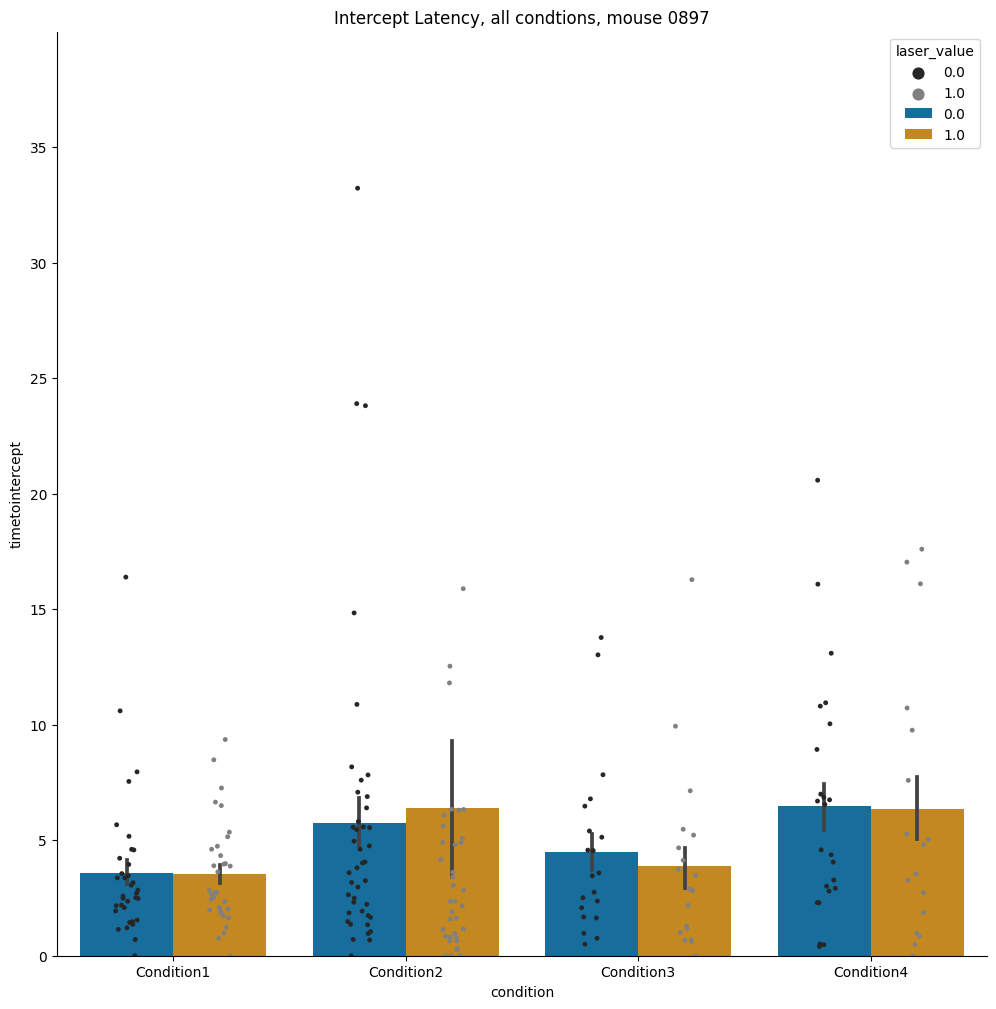

In [131]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0897, x='condition', y='timetointercept', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df0897, color='gray', size=3.5)
plt.ylim(0,40)
plt.yticks(np.arange(0,40,5))
plt.title('Intercept Latency, all condtions, mouse 0897')
sns.despine()

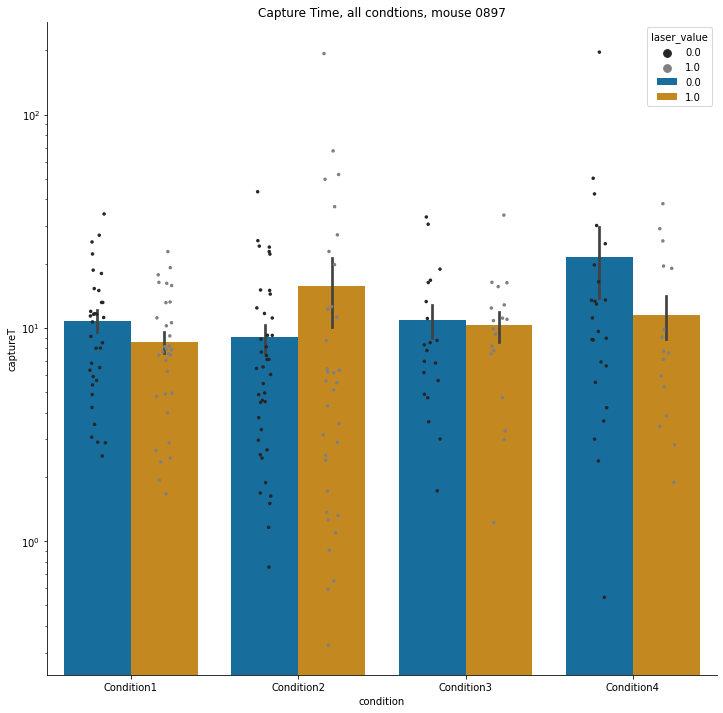

In [21]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0897, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0897, color='gray', size=3.5)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0897')
sns.despine()

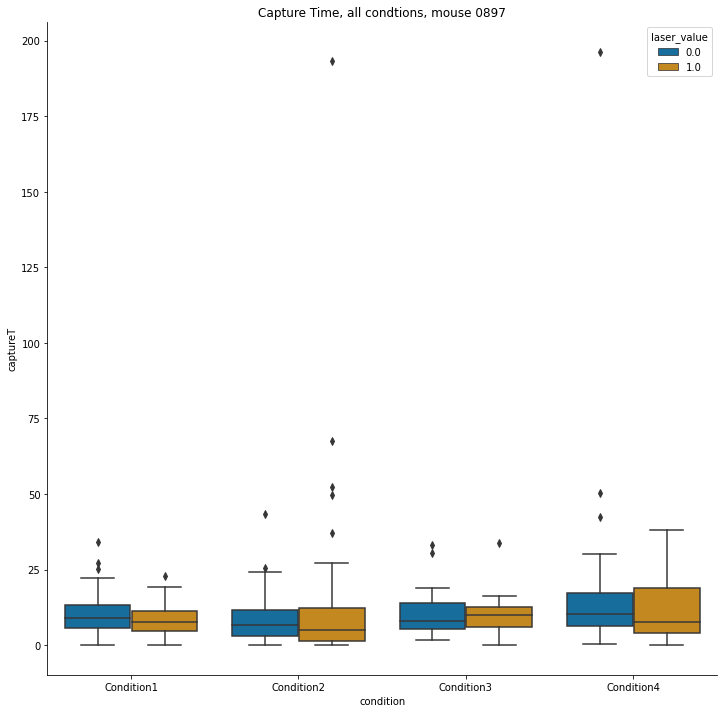

In [22]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df0897, x='condition', y='captureT', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0897')
sns.despine()

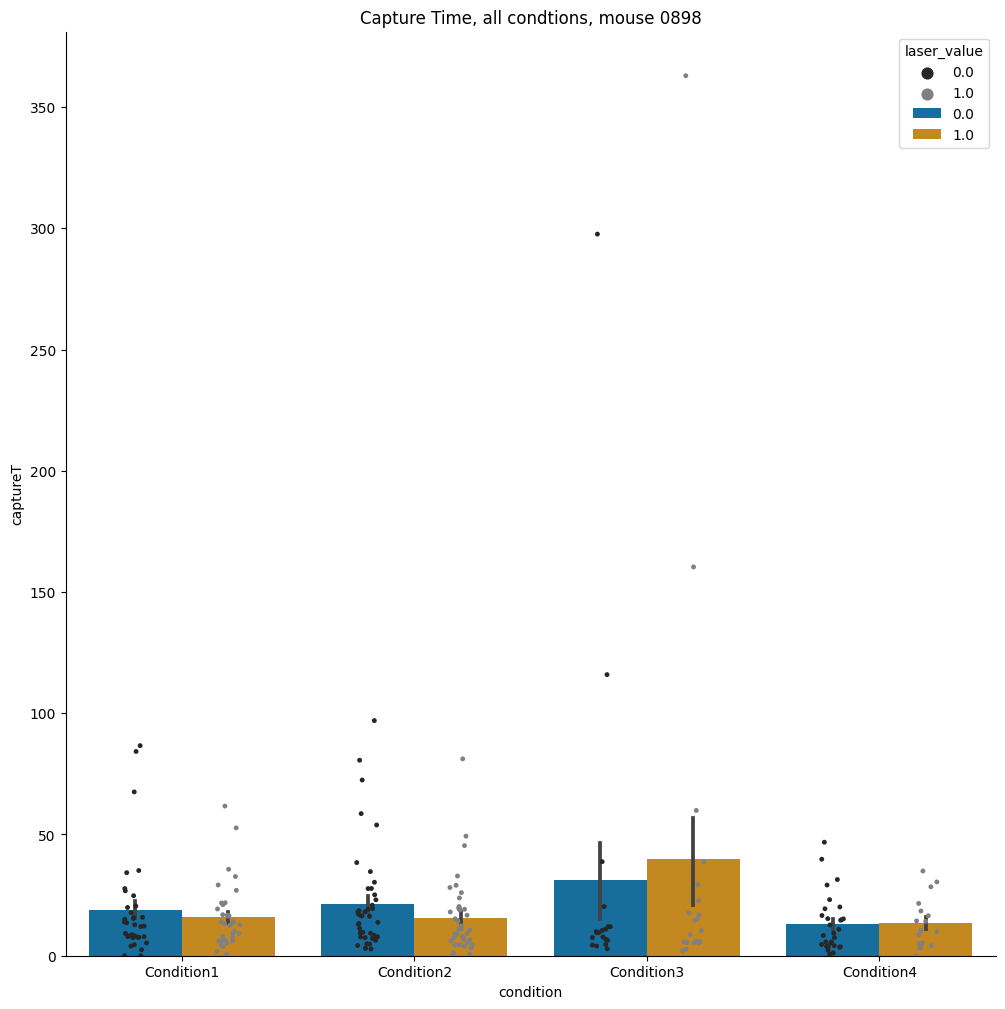

In [132]:
df0898=df[df['filename'].str.contains('0898')]
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0898, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0898, color='gray', size=3.5)
# # plt.ylim(0,50)
plt.title('Capture Time, all condtions, mouse 0898')
sns.despine()

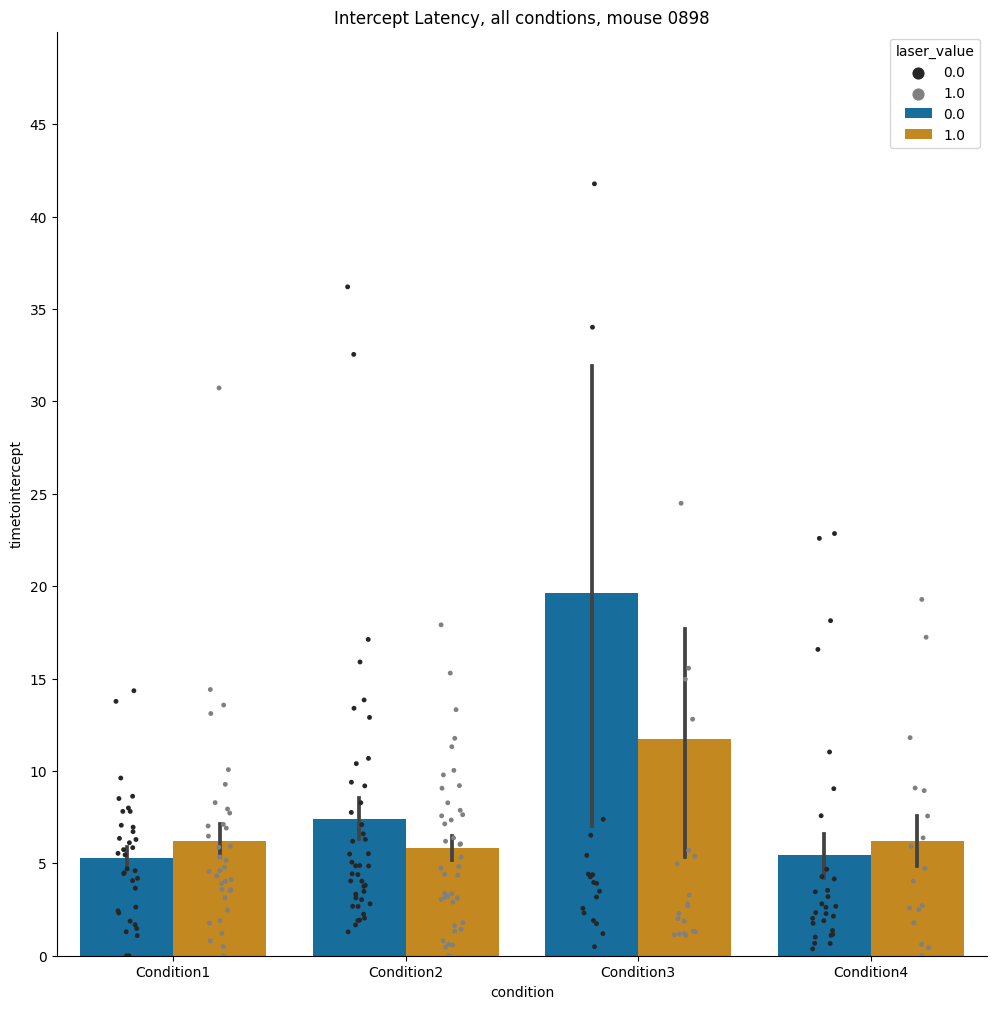

In [135]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0898, x='condition', y='timetointercept', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df0898, color='gray', size=3.5)
plt.ylim(0,50)
plt.yticks(np.arange(0,50,5))
plt.title('Intercept Latency, all condtions, mouse 0898')
sns.despine()

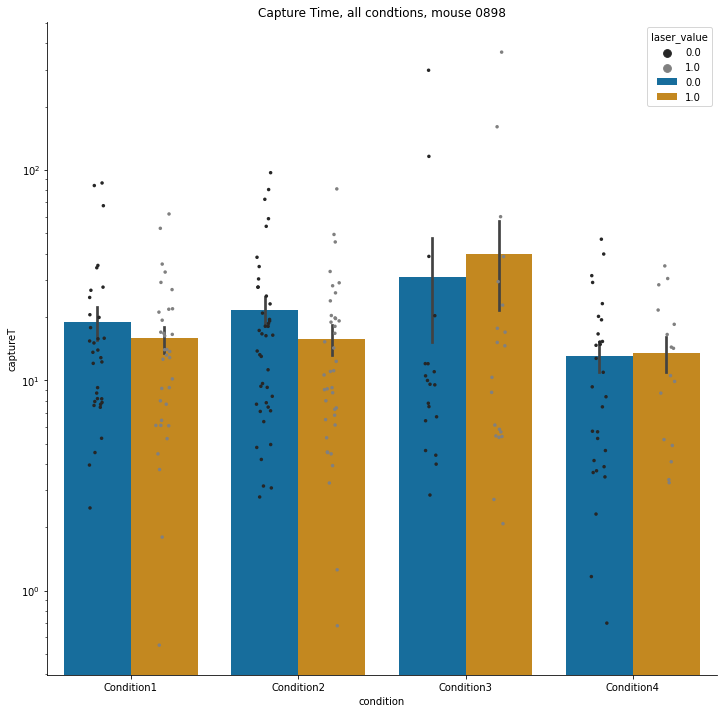

In [24]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0898, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0898, color='gray', size=3.5)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0898')
sns.despine()

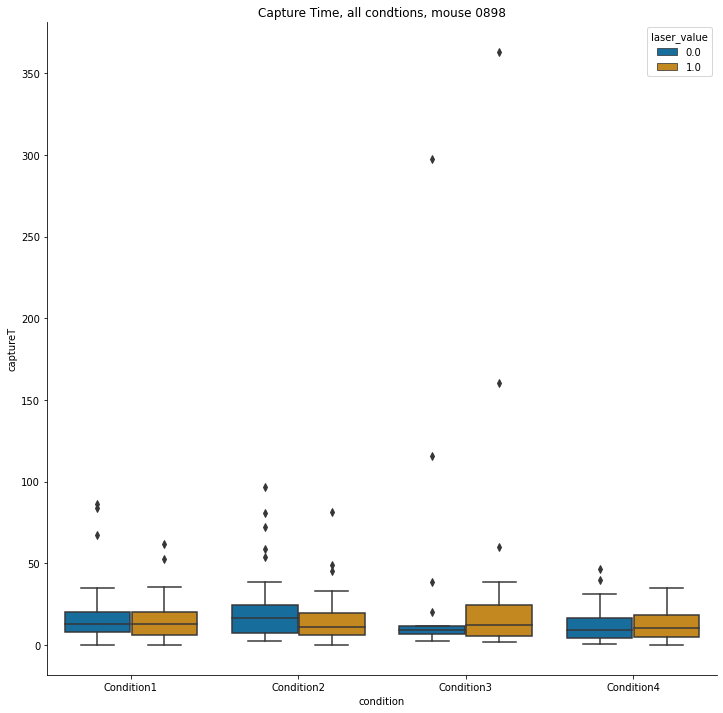

In [25]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df0898, x='condition', y='captureT', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0898')
sns.despine()

In [6]:
df['filename']=df['filename'].astype('str')
type(df['filename'][0])

str

In [137]:
mean_df=df.groupby(['condition','laser_value']).mean()
mean_df

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          32.871143      0.140954        2.476762    0.650588   
           1.0          24.393058      0.115506        2.830340    0.770205   
Condition2 0.0          15.032625      0.117598        2.161458    0.658300   
           1.0          15.337675      0.107697        2.378684    0.627408   
Condition3 0.0          29.790169      0.120615        2.000085    0.753376   
           1.0          22.032034      0.125753        1.614746    0.750816   
Condition4 0.0          16.470000      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  timetointercept  
condition  laser_value                                 
Condition1 0.0              0.453326         6.997571  
           1.0              0.496875         8.942233  
Condition2 0.0              0.662666         7.287958  
           1.0              0.647536         6.722325  
Condition3 0.0              0.502096         9.443136  
           1.0              0.413908         7.627627  
Condition4 0.0              0.599123         7.200062  
           1.0              0.623485         6.008182

In [138]:
med_df=df.groupby(['condition','laser_value']).median()
med_df

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           12.2150      0.132617           1.025    0.666667   
           1.0           11.1400      0.107009           2.120    0.857143   
Condition2 0.0            8.2625      0.109432           1.425    0.600000   
           1.0            8.9450      0.094250           0.750    0.519231   
Condition3 0.0            9.2150      0.102987           1.070    0.800000   
           1.0           10.9600      0.115490           0.600    0.800000   
Condition4 0.0            9.3000      0.080096           1.430    0.666667   
           1.0            7.6250      0.079208           1.345    0.555556   

                        prob_capture  timetointercept  
condition  laser_value                                 
Condition1 0.0              0.333333           4.6050  
           1.0              0.333333           4.5550  
Condition2 0.0              0.500000           4.4125  
           1.0              1.000000           4.8200  
Condition3 0.0              0.333333           3.9150  
           1.0              0.333333           2.8150  
Condition4 0.0              0.500000           3.4850  
           1.0              0.500000           4.8150

In [43]:
test=df[['condition', 'laser_value', 'mouse_spd']]
test

,condition,laser_value,mouse_spd
0,Condition1,0.0,"[14.012931903926157, 16.45841103998438, 19.185..."
1,Condition1,0.0,"[10.771332386653675, 11.611506992090918, 12.79..."
2,Condition1,0.0,"[0.16767258394997434, 0.1256581066396896, 0.21..."
4,Condition1,0.0,"[0.41138057161378183, 0.5378076393260555, 0.72..."
5,Condition1,0.0,"[8.876253093269236, 9.447072818341788, 9.96988..."
...,...,...,...
735,Condition4,1.0,"[3.5382088253352006, 3.5579035878841205, 3.516..."
737,Condition4,1.0,"[1.462482842239078, 1.488112138526609, 1.60963..."
738,Condition4,1.0,"[12.066814973701607, 13.87237568286862, 16.108..."
739,Condition4,1.0,"[0.5426251488004638, 0.6258404237519565, 0.650..."


In [55]:
nonan=test.dropna()
nonan

,condition,laser_value,mouse_spd
0,Condition1,0.0,"[14.012931903926157, 16.45841103998438, 19.185..."
1,Condition1,0.0,"[10.771332386653675, 11.611506992090918, 12.79..."
2,Condition1,0.0,"[0.16767258394997434, 0.1256581066396896, 0.21..."
4,Condition1,0.0,"[0.41138057161378183, 0.5378076393260555, 0.72..."
5,Condition1,0.0,"[8.876253093269236, 9.447072818341788, 9.96988..."
...,...,...,...
735,Condition4,1.0,"[3.5382088253352006, 3.5579035878841205, 3.516..."
737,Condition4,1.0,"[1.462482842239078, 1.488112138526609, 1.60963..."
738,Condition4,1.0,"[12.066814973701607, 13.87237568286862, 16.108..."
739,Condition4,1.0,"[0.5426251488004638, 0.6258404237519565, 0.650..."


In [139]:
from copy import deepcopy as cdc

In [140]:
df

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000,9.675
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040


In [141]:
copydf=cdc(df)
copydf['captureT'][copydf['captureT']>=300]=np.nan

<ipython-input-141-d3a753230c46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copydf['captureT'][copydf['captureT']>=300]=np.nan


In [25]:
copydf=cdc(df_120s)
copydf[copydf['captureT'].values>=110]=np.nan

In [26]:
copydf

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040


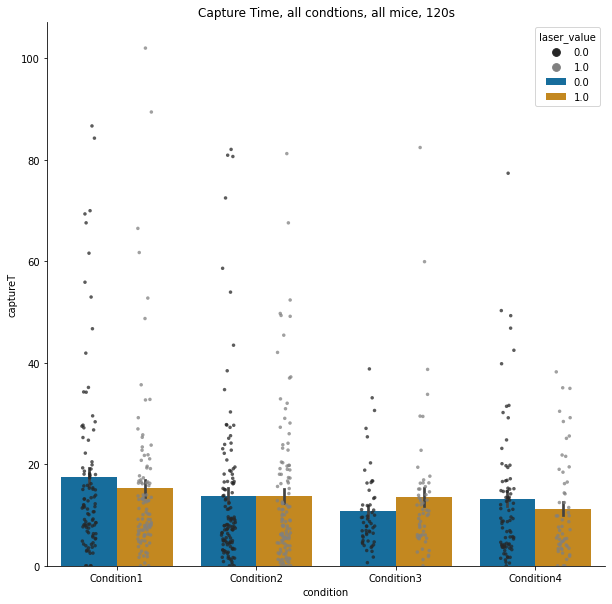

In [27]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=copydf, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=copydf, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice, 120s')
# ax.set_yscale('log')
sns.despine()

In [28]:
mean_copydf=copydf.groupby(['condition','laser_value']).mean()
mean_copydf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          17.493889      0.143323        2.345404    0.671132   
           1.0          15.296535      0.116292        2.700644    0.779796   
Condition2 0.0          13.839664      0.118112        2.153655    0.663100   
           1.0          13.763805      0.107527        2.291018    0.630519   
Condition3 0.0          10.740370      0.121872        1.779444    0.796172   
           1.0          13.625702      0.126701        1.317544    0.764629   
Condition4 0.0          13.162187      0.101126        2.576687    0.696640   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  timetointercept  
condition  laser_value                                 
Condition1 0.0              0.472848         6.169545  
           1.0              0.504239         5.506436  
Condition2 0.0              0.661231         6.398992  
           1.0              0.652160         5.809513  
Condition3 0.0              0.519511         4.669259  
           1.0              0.421234         5.375175  
Condition4 0.0              0.604529         5.753375  
           1.0              0.623485         6.008182

In [29]:
med_copydf=copydf.groupby(['condition','laser_value']).median()
med_copydf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           11.6550      0.138440          1.0250    0.666667   
           1.0           10.5650      0.107623          1.8700    0.875000   
Condition2 0.0            8.1400      0.109499          1.4200    0.600000   
           1.0            8.8750      0.093110          0.7450    0.538462   
Condition3 0.0            8.4200      0.103556          0.9975    1.000000   
           1.0           10.8100      0.115490          0.6000    0.818182   
Condition4 0.0            9.1175      0.079167          1.4175    0.666667   
           1.0            7.6250      0.079208          1.3450    0.555556   

                        prob_capture  timetointercept  
condition  laser_value                                 
Condition1 0.0              0.333333            4.485  
           1.0              0.333333            4.405  
Condition2 0.0              0.500000            4.390  
           1.0              1.000000            4.810  
Condition3 0.0              0.333333            3.535  
           1.0              0.333333            2.795  
Condition4 0.0              0.500000            3.470  
           1.0              0.500000            4.815

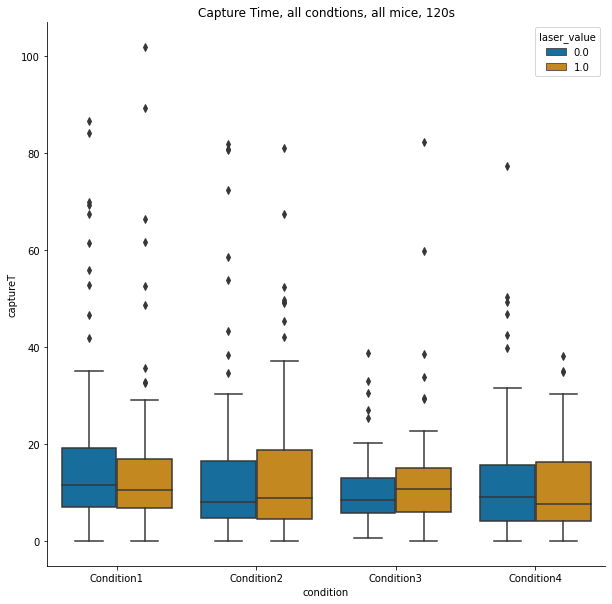

In [30]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(data=copydf, x='condition', y='captureT', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=copydf, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice, 120s')
# ax.set_yscale('log')
sns.despine()

In [52]:
from datetime import datetime as dt
import re
def extract_timestamps(series:pd.Series) -> pd.Series:
    timestamp = series.str.extract('_(\d{4}-[\-\d_T]*)DLC', expand=False)
    return pd.to_datetime(timestamp, format="%Y-%m-%dT%H_%M_%S")
##need to have filename column as type str in order for datetime extraction to be used, won't run on Posix type

In [62]:
copydf=cdc(df)
copydf['timestamps']=extract_timestamps(copydf['filename'])
copydf=copydf.sort_values(by=['condition', 'laser_value','timestamps'])
copydf['sessionID']=ids
copydf

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept,capduration,timestamps,sessionID
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910,62.035,NaT,0
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850,56.460,NaT,1
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000,9.675,189.045,NaT,2
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610,46.085,NaT,3
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845,20.650,NaT,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730,30.215,NaT,50
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280,2.280,NaT,51
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800,2.380,NaT,52
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040,0.055,NaT,53


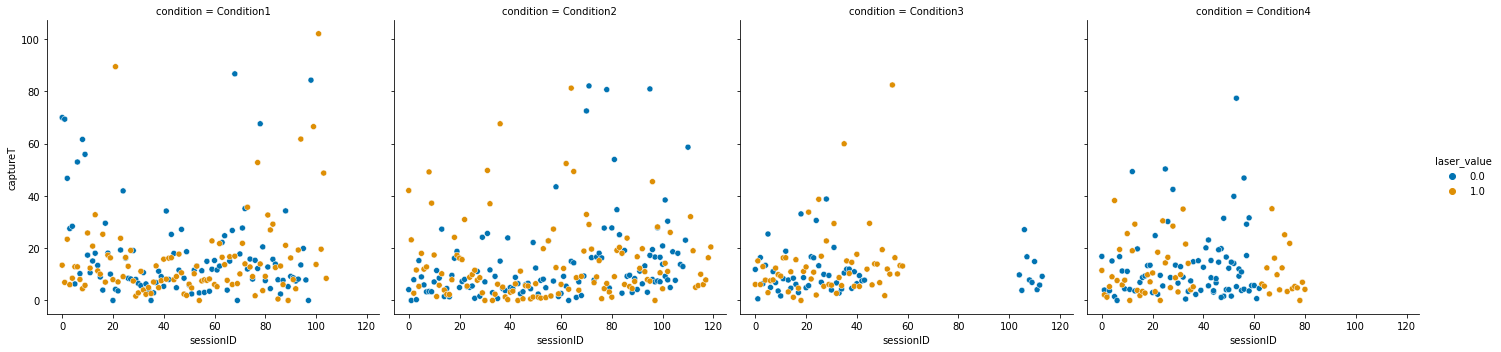

In [58]:
sns.relplot(x='sessionID', y='captureT', col='condition', hue='laser_value', data=copydf,palette="colorblind")
# plt.xlim(0,20)
# plt.ylim(0,100)

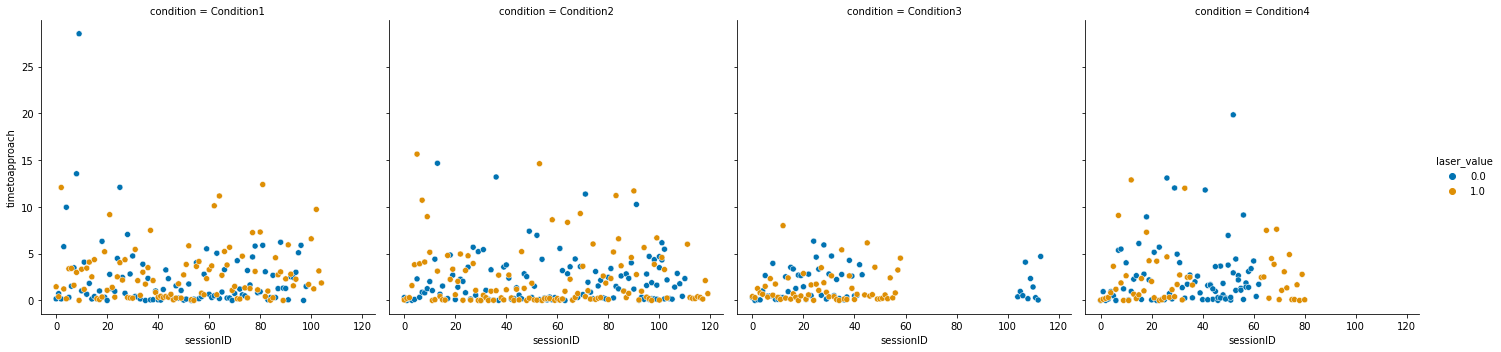

In [59]:
sns.relplot(x='sessionID', y='timetoapproach', col='condition', hue='laser_value', data=copydf,palette="colorblind")
# plt.ylim(0,25)
# plt.xlim(0,20)

(0.0, 50.0)

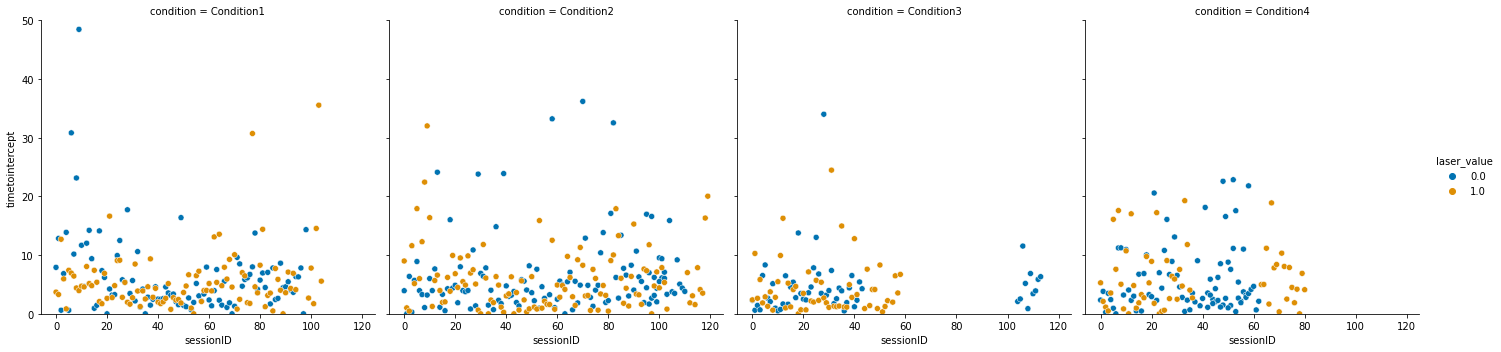

In [60]:
sns.relplot(x='sessionID', y='timetointercept', col='condition', hue='laser_value', data=copydf,palette="colorblind")
plt.ylim(0,50)

(0.0, 100.0)

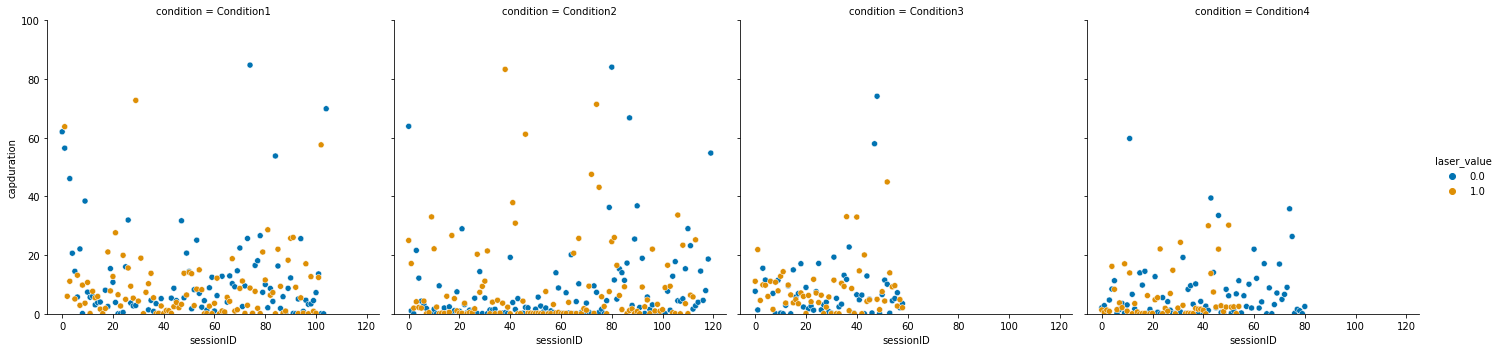

In [67]:
sns.relplot(x='sessionID', y='capduration', col='condition', hue='laser_value', data=copydf,palette="colorblind")
plt.ylim(0,100)
# plt.xlim(0,40)

In [22]:
copydf.groupby(['condition','laser_value']).mean()

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          24.792794      0.140954        2.476762    0.650588   
           1.0          14.429750      0.115506        2.830340    0.770205   
Condition2 0.0          15.032625      0.117598        2.161458    0.658300   
           1.0          15.337675      0.107697        2.378684    0.627408   
Condition3 0.0          24.902414      0.120615        2.000085    0.753376   
           1.0          16.154914      0.125753        1.614746    0.750816   
Condition4 0.0          16.470000      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  sessionID  
condition  laser_value                           
Condition1 0.0              0.453326       52.0  
           1.0              0.496875       51.0  
Condition2 0.0              0.662666       59.5  
           1.0              0.647536       56.5  
Condition3 0.0              0.502096       29.0  
           1.0              0.413908       29.0  
Condition4 0.0              0.599123       40.0  
           1.0              0.623485       27.0

In [54]:
condition1_0=np.arange(0,105)
condition1_1=np.arange(0,103)
condition2_0=np.arange(0,120)
condition2_1=np.arange(0,114)
condition3_0=np.arange(0,59)
condition3_1=np.arange(0,59)
condition4_0=np.arange(0,81)
condition4_1=np.arange(0,55)

In [55]:
ids=np.concatenate([condition1_0,condition1_1,condition2_0,condition2_1,condition3_0,condition3_1,condition4_0,condition4_1])

In [56]:
speedtest=copydf[['condition', 'mouse_spd', 'laser_value', 'sessionID']]

KeyError: "['sessionID'] not in index"

In [155]:
newtest= speedtest.explode('mouse_spd').reset_index().rename(columns={'index':'trial'})
newtest

,trial,condition,mouse_spd,laser_value,sessionID
0,71,Condition1,NaN,0.0,0
1,71,Condition1,NaN,0.0,0
2,71,Condition1,NaN,0.0,0
3,71,Condition1,NaN,0.0,0
4,71,Condition1,NaN,0.0,0
...,...,...,...,...,...
6015645,740,Condition4,0.627422,1.0,54
6015646,740,Condition4,0.541467,1.0,54
6015647,740,Condition4,0.560122,1.0,54
6015648,740,Condition4,0.570266,1.0,54


In [156]:
meanspeed= newtest.groupby(['condition','trial', 'laser_value']).agg({'mouse_spd':np.nanmean})

In [157]:
meanspeed=meanspeed.reset_index()
meanspeed

,condition,trial,laser_value,mouse_spd
0,Condition1,0,0.0,10.951588
1,Condition1,1,0.0,12.884350
2,Condition1,2,0.0,4.742795
3,Condition1,4,0.0,10.143461
4,Condition1,5,0.0,9.198848
...,...,...,...,...
691,Condition4,735,1.0,19.637307
692,Condition4,737,1.0,15.457042
693,Condition4,738,1.0,10.897887
694,Condition4,739,1.0,10.996513


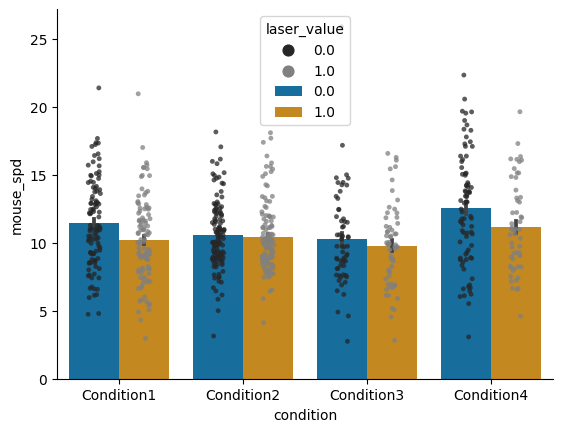

In [158]:
sns.barplot(data=meanspeed,x='condition', y='mouse_spd', hue='laser_value', ci=68,palette="colorblind")
sns.stripplot(x='condition', y='mouse_spd', hue='laser_value',dodge=True, data=meanspeed, color='gray', size=3.5, alpha=0.75)
sns.despine()

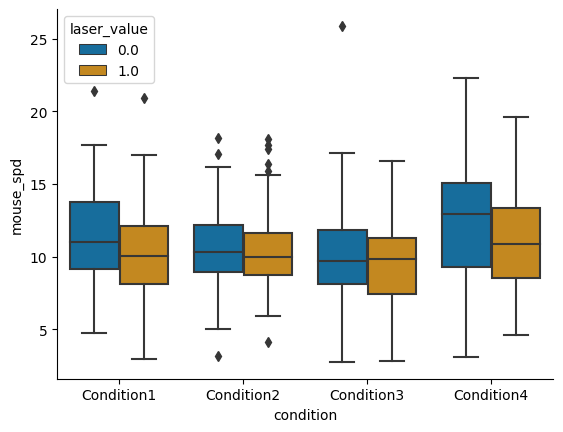

In [89]:
sns.boxplot(data=meanspeed,x='condition', y='mouse_spd', hue='laser_value',palette="colorblind")
sns.despine()

In [31]:
df

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000,9.675
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040


In [32]:
df['capduration']=df['captureT']-df['timetointercept']

In [33]:
df

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept,capduration
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910,62.035
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850,56.460
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000,9.675,189.045
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610,46.085
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845,20.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730,30.215
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280,2.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800,2.380
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040,0.055


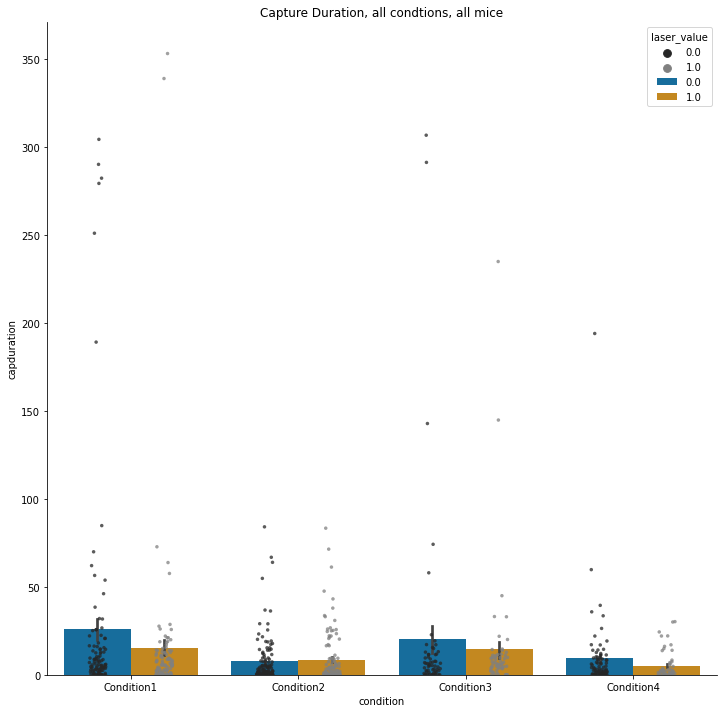

In [34]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='capduration', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='capduration', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Duration, all condtions, all mice')
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
sns.despine()

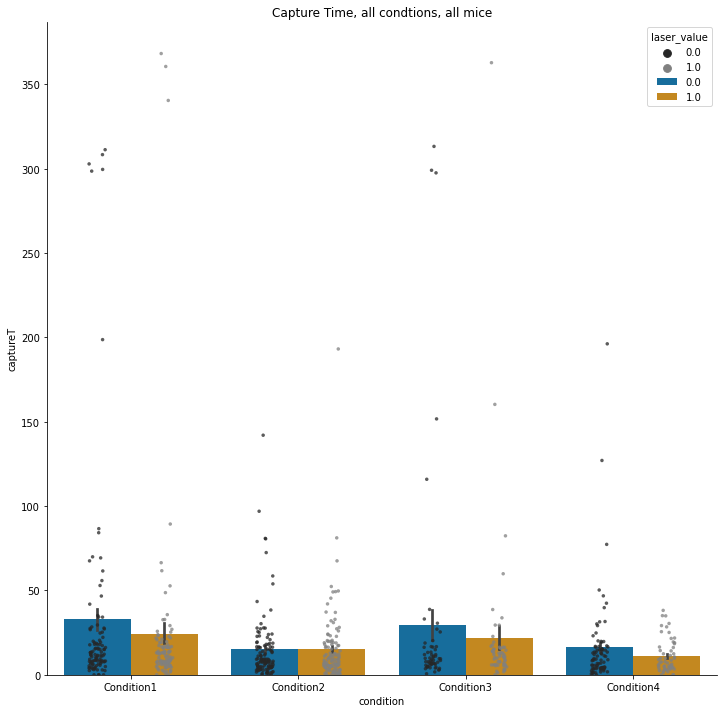

In [35]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice')
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
sns.despine()

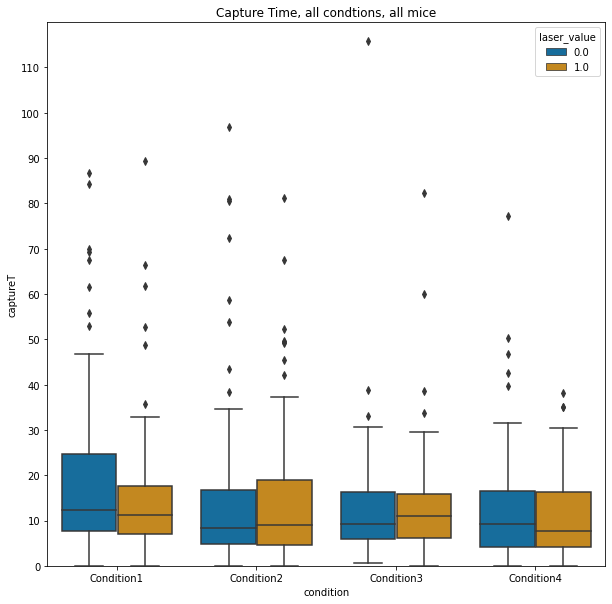

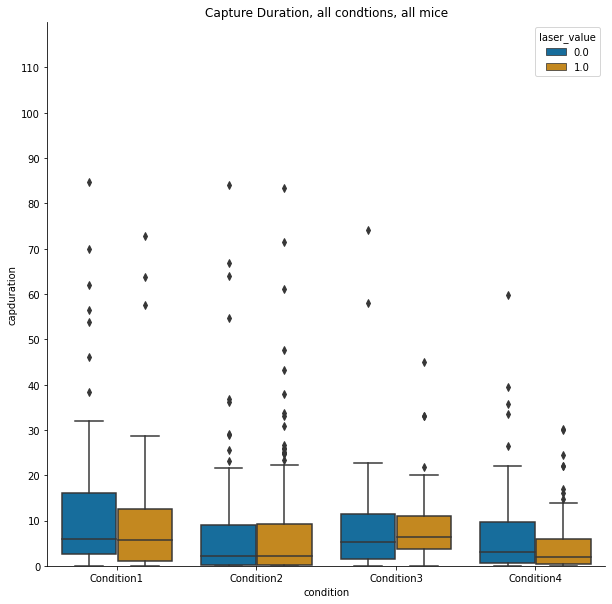

In [48]:
fig1= plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind")
plt.title('Capture Time, all condtions, all mice')
plt.ylim(0,120)
plt.yticks(np.arange(0,120,10))
fig2=plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='condition', y='capduration', hue='laser_value', palette="colorblind")
plt.title('Capture Duration, all condtions, all mice')
plt.ylim(0,120)
plt.yticks(np.arange(0,120,10))
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

In [44]:
mean_df=df.groupby(['condition','laser_value']).mean()
mean_df

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          32.871143      0.140954        2.476762    0.650588   
           1.0          24.393058      0.115506        2.830340    0.770205   
Condition2 0.0          15.032625      0.117598        2.161458    0.658300   
           1.0          15.337675      0.107697        2.378684    0.627408   
Condition3 0.0          29.790169      0.120615        2.000085    0.753376   
           1.0          22.032034      0.125753        1.614746    0.750816   
Condition4 0.0          16.470000      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.453326         6.997571    25.873571  
           1.0              0.496875         8.942233    15.450825  
Condition2 0.0              0.662666         7.287958     7.744667  
           1.0              0.647536         6.722325     8.615351  
Condition3 0.0              0.502096         9.443136    20.347034  
           1.0              0.413908         7.627627    14.404407  
Condition4 0.0              0.599123         7.200062     9.269938  
           1.0              0.623485         6.008182     5.269636

In [45]:
med_df=df.groupby(['condition','laser_value']).median()
med_df

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           12.2150      0.132617           1.025    0.666667   
           1.0           11.1400      0.107009           2.120    0.857143   
Condition2 0.0            8.2625      0.109432           1.425    0.600000   
           1.0            8.9450      0.094250           0.750    0.519231   
Condition3 0.0            9.2150      0.102987           1.070    0.800000   
           1.0           10.9600      0.115490           0.600    0.800000   
Condition4 0.0            9.3000      0.080096           1.430    0.666667   
           1.0            7.6250      0.079208           1.345    0.555556   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.333333           4.6050       5.9750  
           1.0              0.333333           4.5550       5.6050  
Condition2 0.0              0.500000           4.4125       2.1775  
           1.0              1.000000           4.8200       2.0600  
Condition3 0.0              0.333333           3.9150       5.2700  
           1.0              0.333333           2.8150       6.3400  
Condition4 0.0              0.500000           3.4850       3.1400  
           1.0              0.500000           4.8150       1.8850

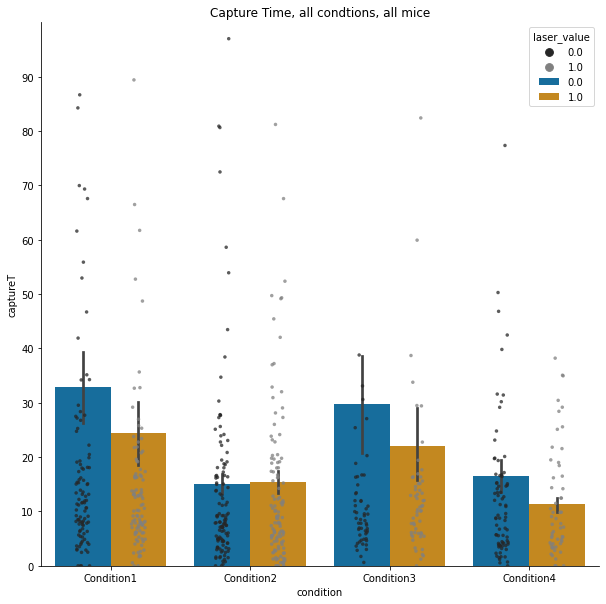

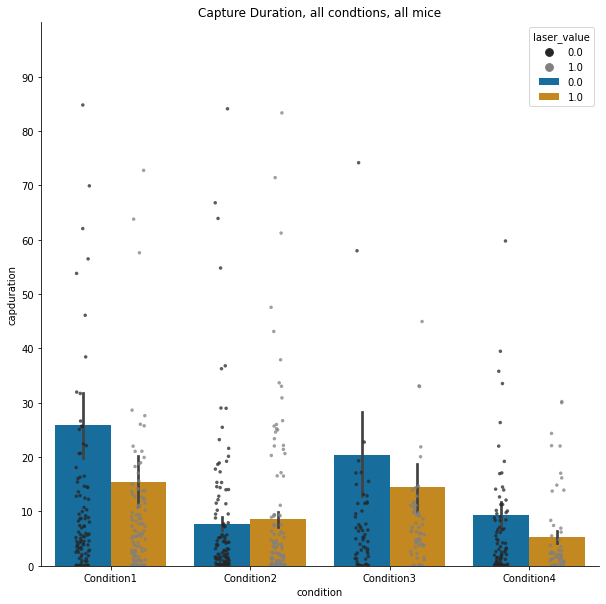

In [69]:
fig1= plt.figure(figsize=(10,10))
ax=sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice')
plt.ylim(0,100)
plt.yticks(np.arange(0,100,10))
sns.despine()
fig2=plt.figure(figsize=(10,10))
ax=sns.barplot(data=df, x='condition', y='capduration', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='capduration', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Duration, all condtions, all mice')
plt.ylim(0,100)
plt.yticks(np.arange(0,100,10))
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

In [131]:
nandf=cdc(df)
nans=np.where(nandf['captureT']>=300)
nanvals=nandf['captureT'].iloc[nans[0]]
nandf=nandf.replace({'captureT':nanvals.values}, np.nan)

In [130]:
nanvals.values

array([308.39 , 302.895, 311.32 , 360.66 , 368.33 , 340.52 , 313.28 ,
       362.905])

In [132]:
nandf

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept,capduration
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910,62.035
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850,56.460
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000,9.675,189.045
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610,46.085
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845,20.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730,30.215
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280,2.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800,2.380
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040,0.055


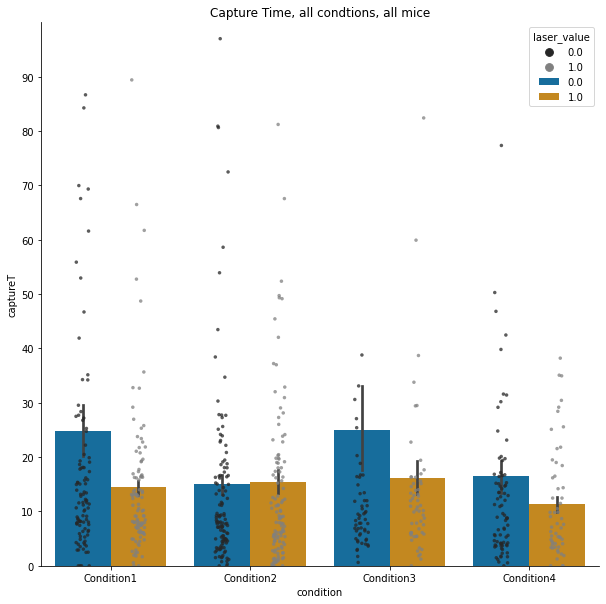

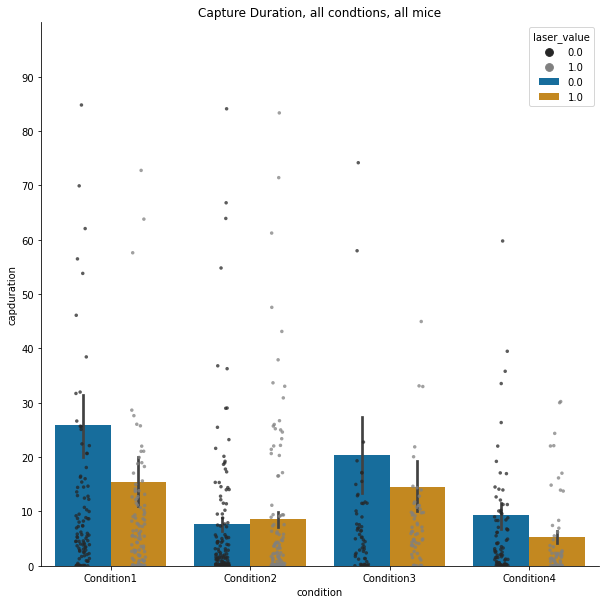

In [135]:
fig1= plt.figure(figsize=(10,10))
ax=sns.barplot(data=nandf, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=nandf, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice')
plt.ylim(0,100)
plt.yticks(np.arange(0,100,10))
sns.despine()
fig2=plt.figure(figsize=(10,10))
ax=sns.barplot(data=nandf, x='condition', y='capduration', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='capduration', hue='laser_value',dodge=True, data=nandf, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Duration, all condtions, all mice')
plt.ylim(0,100)
plt.yticks(np.arange(0,100,10))
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

In [136]:
mean_nandf=nandf.groupby(['condition','laser_value']).mean()
mean_nandf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          24.792794      0.140954        2.476762    0.650588   
           1.0          14.429750      0.115506        2.830340    0.770205   
Condition2 0.0          15.032625      0.117598        2.161458    0.658300   
           1.0          15.337675      0.107697        2.378684    0.627408   
Condition3 0.0          24.902414      0.120615        2.000085    0.753376   
           1.0          16.154914      0.125753        1.614746    0.750816   
Condition4 0.0          16.470000      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.453326         6.997571    25.873571  
           1.0              0.496875         8.942233    15.450825  
Condition2 0.0              0.662666         7.287958     7.744667  
           1.0              0.647536         6.722325     8.615351  
Condition3 0.0              0.502096         9.443136    20.347034  
           1.0              0.413908         7.627627    14.404407  
Condition4 0.0              0.599123         7.200062     9.269938  
           1.0              0.623485         6.008182     5.269636

In [137]:
med_nandf=nandf.groupby(['condition','laser_value']).median()
med_nandf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           11.9825      0.132617           1.025    0.666667   
           1.0           10.3925      0.107009           2.120    0.857143   
Condition2 0.0            8.2625      0.109432           1.425    0.600000   
           1.0            8.9450      0.094250           0.750    0.519231   
Condition3 0.0            8.9725      0.102987           1.070    0.800000   
           1.0           10.8850      0.115490           0.600    0.800000   
Condition4 0.0            9.3000      0.080096           1.430    0.666667   
           1.0            7.6250      0.079208           1.345    0.555556   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.333333           4.6050       5.9750  
           1.0              0.333333           4.5550       5.6050  
Condition2 0.0              0.500000           4.4125       2.1775  
           1.0              1.000000           4.8200       2.0600  
Condition3 0.0              0.333333           3.9150       5.2700  
           1.0              0.333333           2.8150       6.3400  
Condition4 0.0              0.500000           3.4850       3.1400  
           1.0              0.500000           4.8150       1.8850